# Image data classification using ML Random Forest Classifier from Sklearn

**Aim**: to classify the image data of  dog and Dog using Random Forest estimator from Sklearn kit

**Rationale**: curious to see if a ML estimator can perform image classification

**Dataset** :This data set contains two class of images Cats and Dogs. This can be best utilized in a binary classification problem set in computer vision.

**Dataset Source** : Kaggel 

**URL**: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset

# Install Dependency

In [ ]:
%pip install numpy==1.22.3 pandas matplotlib scikit-image scikit-learn joblib opencv-python imageio[pyav]

# Import necessary libraries


In [22]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import os
import joblib
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from skimage.color import rgb2gray
import cv2


# Load, Resize & Store Images in pickle format (.pkl)

In [2]:
# Resize and preprocess images
def resize_all(src, pklname, include, width=150, height=None):
    height = height if height is not None else width
    data = {'description': f'resized ({width}x{height}) mini dog images in rgb', 'label': [], 'filename': [], 'data': []}
    pklname = f"{pklname}_{width}x{height}px.pkl"
    for subdir in os.listdir(src):
        if subdir in include:
            current_path = os.path.join(src, subdir)
            for file in os.listdir(current_path):
                if file.endswith(('jpg', 'png')):
                    try:
                        im = imread(os.path.join(current_path, file))
                        if im.ndim != 3 or im.shape[2] != 3:
                            continue
                        im_resized = resize(im, (width, height))
                        data['label'].append(subdir)
                        data['filename'].append(file)
                        data['data'].append(im_resized)
                    except (OSError, ValueError, IndexError, EOFError) as e:
                        print(f"Error processing {file}: {e}")
                        continue
    joblib.dump(data, pklname)


    

In [3]:
# Usage
IMAGE_PATH = 'PetImages'
CLASSES = ['Dog', 'Cat']
BASE_NAME = 'Dog_and_Cat'
WIDTH = 90

resize_all(src=IMAGE_PATH, pklname=BASE_NAME, width=WIDTH, include=CLASSES)


Error processing 10404.jpg: attempt to seek outside sequence
Error processing 666.jpg: Could not find a backend to open `PetImages\Cat\666.jpg`` with iomode `r`.
Error processing 11702.jpg: Could not find a backend to open `PetImages\Dog\11702.jpg`` with iomode `r`.


# Read and preprocess data

In [9]:
# Read and preprocess data
data = joblib.load(f'{BASE_NAME}_{WIDTH}x{WIDTH}px.pkl')
x = np.array(data['data'])
y = np.array(data['label'])

# Split the dataset
SIZE = 0.1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=SIZE, shuffle=True, random_state=42)

# Normalize the images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Feature extraction using HOG


In [11]:
# Feature extraction using HOG
def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_gray = rgb2gray(image)
        features = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)
x_train_hog = extract_hog_features(x_train)
x_test_hog = extract_hog_features(x_test)


# Hyperparameter tuning


In [16]:
# Hyperparameter tuning in batches to avoid memory issues
from sklearn.model_selection import train_test_split

# Split the training data into smaller batches
batch_size = 1000  # Adjust batch size based on available memory
n_batches = len(x_train_hog) // batch_size + 1

# Initialize an empty list to store best parameters from each batch
best_params_list = []

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Iterate through batches
for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, len(x_train_hog))
    
    # Extract batch data
    x_batch = x_train_hog[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]
    
    # Initialize RandomizedSearchCV for the current batch
    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=param_grid,
                                   n_iter=10,  # Adjust number of iterations as needed
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)
    
    # Fit RandomizedSearchCV on the current batch
    rf_random.fit(x_batch, y_batch)
    
    # Append best parameters for the current batch to best_params_list
    best_params_list.append(rf_random.best_params_)
    
    print(f"Processed batch {i+1}/{n_batches} from index {start_idx} to {end_idx}")

# Function to aggregate best parameters from all batches
def aggregate_best_params(best_params_list):
    param_counts = {}
    for params in best_params_list:
        for key, value in params.items():
            if key not in param_counts:
                param_counts[key] = {}
            if value not in param_counts[key]:
                param_counts[key][value] = 0
            param_counts[key][value] += 1
    
    # Choose the most frequent parameter value for each parameter
    best_params = {key: max(value_counts, key=value_counts.get) for key, value_counts in param_counts.items()}
    return best_params

# Aggregate best parameters from all batches
best_params = aggregate_best_params(best_params_list)
print("Aggregated best parameters:", best_params)

# Create the final model with aggregated best parameters
rfc_t = RandomForestClassifier(**best_params)

# Fit the final model on the entire training dataset
rfc_t.fit(x_train_hog, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 1/23 from index 0 to 1000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 2/23 from index 1000 to 2000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 3/23 from index 2000 to 3000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 4/23 from index 3000 to 4000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 5/23 from index 4000 to 5000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 6/23 from index 5000 to 6000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 7/23 from index 6000 to 7000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 8/23 from index 7000 to 8000
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processed batch 9/23 from index 8000 to 9000
Fitting 3 folds for each of 10 candidates, totall

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300)

# Fit and predict and calculate accurracy

In [23]:
# Fit and predict

y_pred = rfc_t.predict(x_test_hog)

In [24]:
acc = '{:.1%}'.format(accuracy_score(y_test, y_pred))
print(f"Accuracy for Random Forrest (tuned): {acc}")

Accuracy for Random Forrest (tuned): 70.6%


# Custom prediction function and Predict custom images

The predicted label for the custom image is: Dog



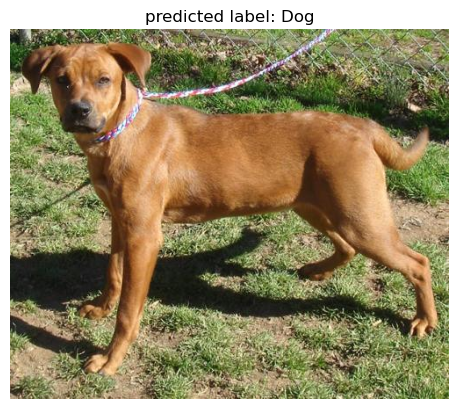

The predicted label for the custom image is: Cat



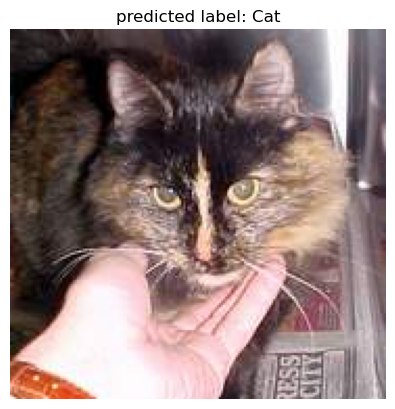

The predicted label for the custom image is: Cat



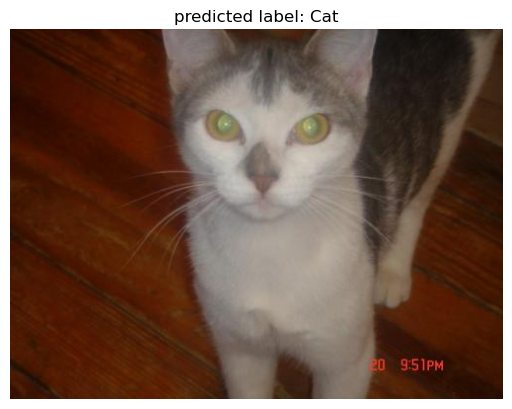

In [25]:
# Custom prediction function
def predict_label(path, model, width=90):
    img_arr = cv2.imread(path)
    img_arr = cv2.resize(img_arr, (width, width))
    img_arr = img_arr / 255.0
    img_gray = rgb2gray(img_arr)
    features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    img_arr2 = features.reshape(1, -1)
    custom_pred = model.predict(img_arr2)
    print(f"The predicted label for the custom image is: {custom_pred[0]}\n")
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("predicted label: " + custom_pred[0])
    plt.show()

# Predict custom images
predict_label('55.jpg', rfc_t)
predict_label('60.jpg', rfc_t)
predict_label('12489.jpg', rfc_t)